# PHYS 481  - Automata entropy

This definition of entropy

  $$ S = \sum\limits_i^N p_i \log_2 p_i $$
  
requires probabilities for each of $N$ possible outcomes.  If there is no theoretical or other source of information about "true" probabilities then it may be necessary to make empirical (aka frequentist) estimates

  $$ p_i \approx \frac{n_i}{N} $$
  
For some systems it is straightforward to identify the appropriate set of $N$ outcomes eg. flipping a coin.  Other cases may be less obvious.  For a monkey with a typewriter the atomic (smallest indivisible) operation is hitting a single key.  However, there is nothing stopping us from considering groups of 2 or more characters, perhaps corresponding to phonetic elements of speech.  This might be useful when designing a voice synthesis device.  An argument might also be made for working with individual words or entire sentences.

## The point here is that some thought should be given to choosing and defining the symbols (events) before carring out entropy calculations.

For a 1-dimensional cellular automaton the atomic event is the state of a single cell

       [0, 1, 0, 1, 1, ... ]
  
The output from a single cell at successive time steps could also be grouped to produce a shorter sequence of compound symbols which could also be converted from a binary representation

       [0, 1, 1, 0, ...] => [(0,1), (1,0), ....] => [1, 2, ...]
       
Multiple cells might be grouped together at each time step to produce a sequence of binary tuples.

       [0,1,0,1,...] => [(0,0),(1,1),(0,1),(1,0),...] => [0,3,1,2,...]
       [0,1,1,0,...]       

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def symbol_entropy(symbol_sequence, group_nsymbols=1):
    """
    Taken from spamlet notes.
    """
    countdict = {}
    nseq = len(symbol_sequence)

    for indx in range( 0, nseq-group_nsymbols): #nseq-group_nsymbols): #, group_nsymbols):
        symbol = tuple( symbol_sequence[indx:indx+group_nsymbols] )
        if symbol in countdict:
            countdict[symbol] += 1
        else:
            countdict[symbol] = 1
            
    counts = np.array( [countdict[symbol] for symbol in countdict]) #; print(counts)
    prob = counts / np.sum(counts)
    entropy = -np.sum( prob * np.log2(prob) ) #/ group_nsymbols
    
    return dict( entropy=entropy , symbols = list(countdict.keys()) )

#s = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
#print( symbol_entropy(s, 1) )
#print( symbol_entropy(s, 2) )

In [3]:
def cellular_step(value, rule_number=110):
    """You are welcome to use this code, but you have to explain how it works.
    Otherwise you will need to write your own.
    
    Debugging is twice as hard as writing the code in the first place. 
    Therefore, if you write the code as cleverly as possible, you are, 
    by definition, not smart enough to debug it.
    https://www.linusakesson.net/programming/kernighans-lever/index.php    
    """
    lookup = np.unpackbits( np.uint8(rule_number) )[::-1]
    triple = np.roll(value,+1)*4 + value*2 + np.roll(value,-1)
    
    return lookup[triple]

In [4]:
def automata1d_stepgrid(ncells=64, nsteps=999, rule_number=1, entropy_group=(1,2,3), entropy_cell=None, plot_grid=False):
    """
    based on 1d cellular automata class notes
    """
    value = np.zeros(ncells, dtype=np.int8)
    value[ len(value)//2 ] = 1  # initialize middle cell

    grid = np.ndarray( [nsteps, len(value)], dtype=np.int8)

    for n in range(nsteps):
        value = cellular_step(value, rule_number=rule_number)
        grid[n,:] = value
     
    entropy_cell = ncells//2 if entropy_cell is None else entropy_cell        
    entropy = {}
    for ngroup in entropy_group: #[1,2,3,4]:
        entropy[ngroup] = symbol_entropy( grid[100:,entropy_cell] , ngroup )
    
    if plot_grid:
        plt.imshow(grid.T)
        plt.grid(False)
        plt.ylabel('cell number')
        plt.xlabel('step number')
        plt.title('CA rule '+str(rule_number))
        plt.xlim(0, 199) #nsteps) #5000,5150)                
            
    return dict( grid=grid, entropy=entropy )
            
#result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=110, plot_grid=True ) 
#for name,value in result['entropy'].items():
#    print( name, value)

### Rule 50

Initialize rule 50 for 64 cells with all zero except cell 32.  The resulting change spreads out at a "speed-of-light" of one cell per step.

A single cell (#32) produces a sequence with an equal number of 0's and 1's, which corresponds to an entropy of 1 bit per step.  However, the sequence does not look very random as it just alternates between states.       

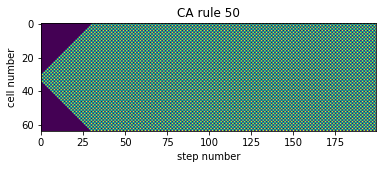

In [5]:
result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=50, plot_grid=True ) 

Text(0.5, 0, 'cell number')

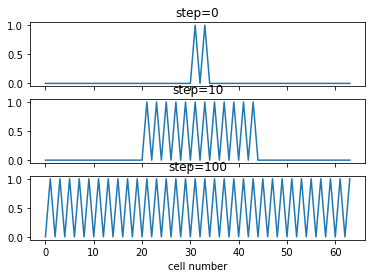

In [6]:
grid = result['grid']
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
axes[0].plot( grid[0,:] ) ; axes[0].set_title('step=0') #', label='0', lw=4 )
axes[1].plot( grid[10,:] ) ; axes[1].set_title('step=10') #, label='30' )
axes[2].plot( grid[100,:] ) ; axes[2].set_title('step=100') #, label='300' )
plt.xlabel('cell number')

(0.0, 200.0)

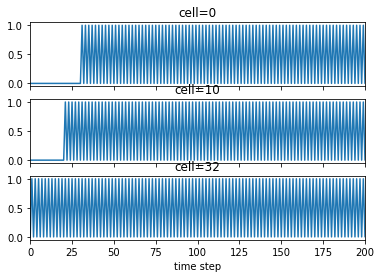

In [7]:
grid = result['grid']
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
axes[0].plot( grid[:,0] ) ; axes[0].set_title('cell=0') #', label='0', lw=4 )
axes[1].plot( grid[:,10] ) ; axes[1].set_title('cell=10') #, label='30' )
axes[2].plot( grid[:,32] ) ; axes[2].set_title('cell=32') #, label='300' )
plt.xlabel('time step')
plt.xlim(0,200)

In [8]:
for name,value in result['entropy'].items():
    print( name, value)

1 {'entropy': 1.0, 'symbols': [(0,), (1,)]}
2 {'entropy': 0.9999991034804858, 'symbols': [(0, 1), (1, 0)]}
3 {'entropy': 1.0, 'symbols': [(0, 1, 0), (1, 0, 1)]}


One way to understand this is to study the output produced from two successive time steps.  It turns out that there are only two outcomes, with 0 always followed by 1 and always 1 followed by 0.  There are never any cases with sucessive 0's or 1's.  The two pair outcomes are equally probable, so the entropy is 1 bit per pair (or 0.5 bits per step).  This can be compared to a completely random case with 4 equally probable outcomes having 2 bits per pair (or one bit per step).

Similarly, grouping the sequence into triplets results in only two equally probable cases with an entropy of 1 bit per 3-steps (0.3333 bits per step).  In contrast, a perfectly random sequence should have an entropy of 3 bits per triplet (or one bit per step). 

### Rule 150

This rule looks like it should be at least somewhat random, but initial attempts to calculate entropy were all zero.

The problem is that my code defaults to using the middle cell which is always True for this sequence.

If instead we look at cell=9 the resulting entropy estimates are all greater than zero but less than half what would be expected from a purely random process.

1 {'entropy': -0.0, 'symbols': [(1,)]}
2 {'entropy': -0.0, 'symbols': [(1, 1)]}
3 {'entropy': -0.0, 'symbols': [(1, 1, 1)]}


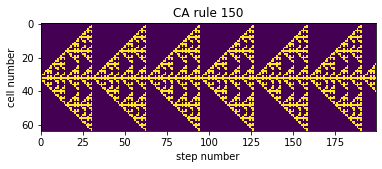

In [9]:
result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=150, plot_grid=True ) 
for name,value in result['entropy'].items():
    print( name, value)

In [10]:
result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=150, plot_grid=False, entropy_cell=9 ) 
for name,value in result['entropy'].items():
    print( name, value)

1 {'entropy': 0.4481807208144867, 'symbols': [(0,), (1,)]}
2 {'entropy': 0.8830608246615479, 'symbols': [(0, 0), (0, 1), (1, 0)]}
3 {'entropy': 1.2876878900165245, 'symbols': [(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 1), (1, 0, 0)]}


### Rule 110

This case looks highly structured, with quasi-periodic patterns of triangles with a range of sizes.  

Surpisingly (to me) the entropy estimates are fairly high: roughly 90% of a perfectly random process.

1 {'entropy': 0.9255414873956127, 'symbols': [(1,), (0,)]}
2 {'entropy': 1.8106389219635854, 'symbols': [(1, 1), (1, 0), (0, 0), (0, 1)]}
3 {'entropy': 2.5968285561040547, 'symbols': [(1, 1, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)]}


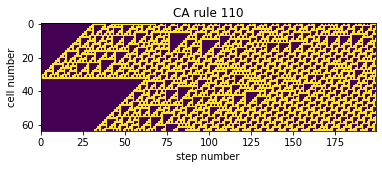

In [11]:
result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=110, plot_grid=True ) 
for name,value in result['entropy'].items():
    print( name, value)

### Rule 73

This case may appear to be fairly random, but the entropy estimates are fairly low: about 60% of ideal randomness.

1 {'entropy': 0.6162128852179952, 'symbols': [(0,), (1,)]}
2 {'entropy': 1.1933289077340465, 'symbols': [(0, 1), (1, 0), (0, 0)]}
3 {'entropy': 1.76863904336966, 'symbols': [(0, 1, 0), (1, 0, 0), (0, 0, 0), (0, 0, 1), (1, 0, 1)]}


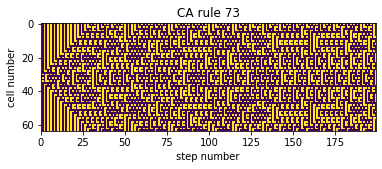

In [12]:
result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=73, plot_grid=True, entropy_cell=9 ) 
for name,value in result['entropy'].items():
    print( name, value)

### Rule 30

This case appears to be less structured than Rule 110 but not (to my eye) totally random.

Interestingly, the entropy estimates are basically the same as would be expected for a ideally random process.

1 {'entropy': 0.9997709898052844, 'symbols': [(0,), (1,)]}
2 {'entropy': 1.9994336791905885, 'symbols': [(0, 1), (1, 1), (1, 0), (0, 0)]}
3 {'entropy': 2.9970548809237787, 'symbols': [(0, 1, 1), (1, 1, 1), (1, 1, 0), (1, 0, 0), (0, 0, 1), (1, 0, 1), (0, 0, 0), (0, 1, 0)]}


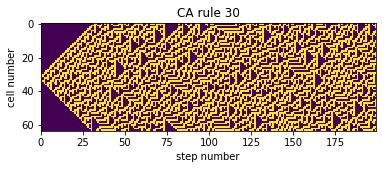

In [13]:
result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=30, plot_grid=True ) 
for name,value in result['entropy'].items():
    print( name, value)

In [14]:
#for cellnum in [0,5,30,60]:
#    result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=30, 
#        plot_grid=True, entropy_cell=cellnum, entropy_group=(1,2,3) ) 
#    print( '\n cell number = '+str(cellnum) ) 
#    for name,value in result['entropy'].items():
#        print( name, value )    

#### Question: do the entropies depend on cell number?

Plotting the entropies for each cell gives a fairly random result, but with a noticable dip around cells 19 and 23.  A more thorough examination would involve repeating this analysis with a larger number of steps in order to quantify statistical fluctuations.

In [15]:
stack = []
rulenum = 30
for cellnum in range(0,64):
    result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=rulenum, 
        plot_grid=False, entropy_cell=cellnum, entropy_group=(1,2,3) ) 
    ent = result['entropy']    
    stack.append( (ent[1]['entropy'], ent[2]['entropy'], ent[3]['entropy']) )

stack = np.array(stack)

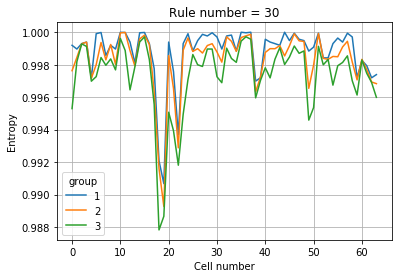

In [16]:
for indx,entnum in enumerate([1,2,3]):
    plt.plot(stack[:,indx] / entnum, label=str(entnum))  
plt.title('Rule number = '+str(rulenum))
plt.ylabel('Entropy')
plt.xlabel('Cell number')
plt.legend(loc=0, title='group')
plt.grid('True')

## Random rules

Looping over all rules gives quite a few with high single-step entropies.  Grouping together step pairs eliminates many of these, while considering triplets only removes a few more.

There are 10 rules with 3-step entropies greater than 2.90 and four greater than or equal to 2.95: 89, 30, 135, 75.  In my opinion, all of these appear to be equally random.

In [17]:
stack = []
cellnum = 33
for rulenum in range(0,256):
    result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=rulenum, 
        plot_grid=False, entropy_cell=cellnum, entropy_group=(1,2,3) ) 
    ent = result['entropy']
    stack.append( (ent[1]['entropy'], ent[2]['entropy'], ent[3]['entropy']) )
                 
stack = np.array(stack)                 

[ 19 122  39 119 186 117  37 114  31  29  27 107  23  63 121 127]
[131 145 193 137 101  86  45 149  89 158 214 110  30 124 135  75]
[246 214 158 150 193 137 101 110  86 149 124  45  89  30 135  75]


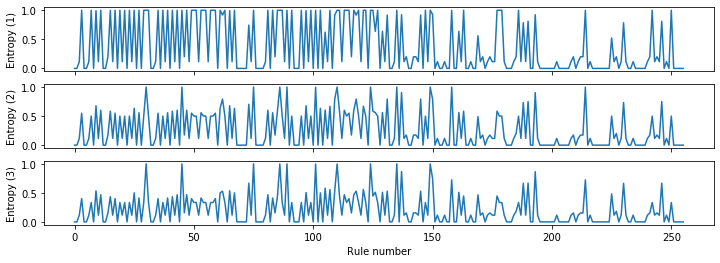

In [18]:
#print(stack.shape)
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(12,4) )
for indx,entnum in enumerate([1,2,3]):
    group_entropy = stack[:,indx] / entnum
    axes[indx].plot(group_entropy)
    axes[indx].set_ylabel('Entropy ('+ str(entnum)+')' )
    print( np.argsort(group_entropy)[-16:] )
plt.xlabel('Rule number')
bestrules = np.argsort(group_entropy)[-15:]

[214 158 150 193 137 101 110  86 149 124  45  89  30 135  75] [0.72288168 0.72288168 0.74591204 0.86325652 0.86509122 0.99589478
 0.99648715 0.99689117 0.99719296 0.99773352 0.99800629 0.99834837
 0.99838284 0.99906479 0.99964708]


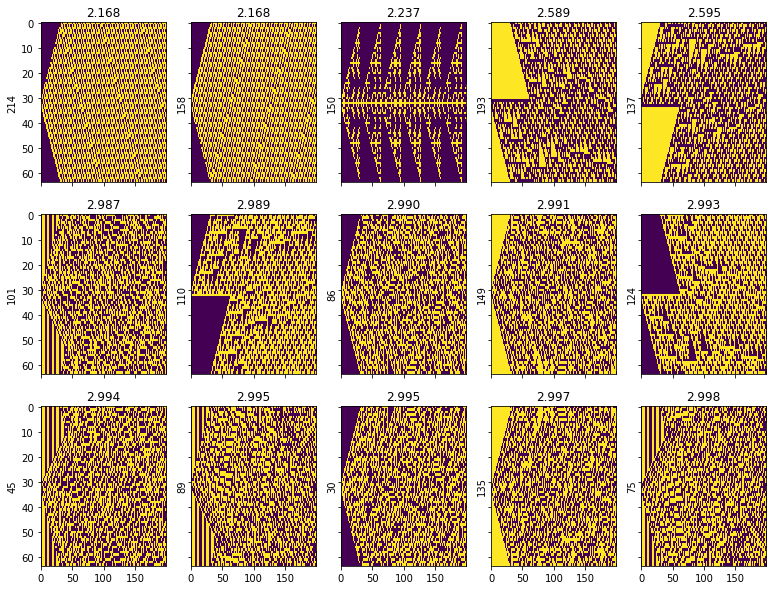

In [19]:
bestrules = np.argsort(group_entropy)[-15:]
print(bestrules, group_entropy[bestrules])
fig, axes = plt.subplots(3,5, figsize=(13,10), sharex=True, sharey=True )
for indx,rulenum in enumerate( bestrules ):
    result = automata1d_stepgrid(ncells=64, nsteps=999, rule_number=rulenum, 
        plot_grid=False, entropy_cell=cellnum, entropy_group=(1,2,3) )
    ax = axes.flatten()[indx]
    ax.imshow( result['grid'].T, aspect='auto' )
    ax.set_title(str(result['entropy'][3]['entropy'])[0:5])
    ax.set_ylabel( str(rulenum))
    ax.set_xlim(0,199)

## Discussion

Calculating the entropy for a sequence implicitly assumes that the symbols are independent.  Relationships between sucessive elements may be detected by considering groups of symbols.  However, empirical probability estimates for large groups may require unreasonably large amounts of data.

For 1D "Wolfram" cellular automata there appear to be 10 high-entropy rules which may be suitable for random number generation.

Optional work: explore "spatial" relationships between adjacent cells ie. groups of 2, 3, ...